In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
from dotenv import load_dotenv
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("../../Datasets/3_earthquake_1995-2023.csv")

df.drop(columns=['title', 'day', 'month', 'year', 'location', 'country'], inplace=True)

Null values in dataset:
magnitude    0
cdi          0
mmi          0
alert        0
tsunami      0
sig          0
net          0
nst          0
dmin         0
gap          0
magType      0
depth        0
latitude     0
longitude    0
continent    0
dtype: int64


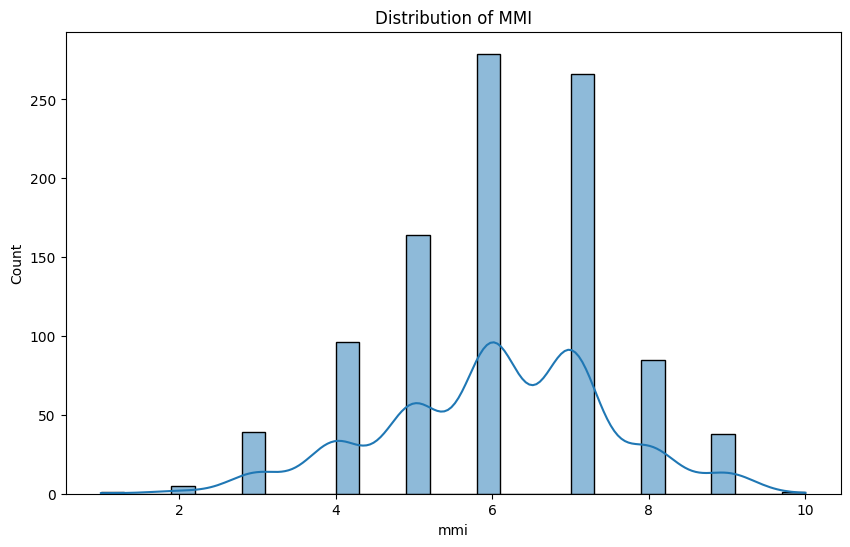

In [3]:
# Check null values and data distribution
print("Null values in dataset:")
print(df.isna().sum())

plt.figure(figsize=(10, 6))
sns.histplot(df['mmi'], kde=True, bins=30)
plt.title('Distribution of MMI')
plt.show()

In [4]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

In [5]:
# Separate features and target
X = df.drop(columns=['mmi'])
y = df['mmi']

# Identify feature types
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns


In [6]:
# Initialize transformers
transformers = {
    'label_encoders': {},
    'scaler': StandardScaler(),
    'target_encoder': LabelEncoder()
}

# Transform categorical features
X_transformed = X.copy()
for col in categorical_features:
    transformers['label_encoders'][col] = LabelEncoder()
    X_transformed[col] = transformers['label_encoders'][col].fit_transform(X[col])

# Transform numerical features
X_transformed[numerical_features] = transformers['scaler'].fit_transform(X[numerical_features])

# Transform target variable
y_transformed = transformers['target_encoder'].fit_transform(y)

In [7]:
# Print original class distribution
print("\nOriginal class distribution:")
class_distribution = pd.Series(y_transformed).value_counts()
print(class_distribution.sort_index())

min_samples = class_distribution.min()
print(f"\nMinimum samples in any class: {min_samples}")

# Perform train-test split without stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_transformed, 
    y_transformed,
    test_size=0.2,
    random_state=42
)



Original class distribution:
0      1
1      5
2     39
3     96
4    164
5    279
6    266
7     85
8     38
9      1
Name: count, dtype: int64

Minimum samples in any class: 1


In [8]:
from imblearn.over_sampling import SMOTENC, RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline

In [9]:
# Print original class distribution
print("\nOriginal class distribution:")
class_distribution = pd.Series(y_transformed).value_counts()
print(class_distribution.sort_index())



Original class distribution:
0      1
1      5
2     39
3     96
4    164
5    279
6    266
7     85
8     38
9      1
Name: count, dtype: int64


In [10]:
# Identify categorical feature indices for SMOTENC
categorical_feature_indices = [i for i, col in enumerate(X_transformed.columns) 
                             if col in categorical_features]

# First use RandomOverSampler to handle classes with very few samples
ros = RandomOverSampler(random_state=42)
X_temp, y_temp = ros.fit_resample(X_train, y_train)

print("\nClass distribution after Random Oversampling:")
print(pd.Series(y_temp).value_counts().sort_index())


Class distribution after Random Oversampling:
0    233
1    233
2    233
3    233
4    233
5    233
6    233
7    233
8    233
9    233
Name: count, dtype: int64


In [11]:
# Then apply SMOTENC to create synthetic samples while respecting categorical features
smotenc = SMOTENC(
    categorical_features=categorical_feature_indices,
    random_state=42,
    k_neighbors=2,  # Minimum possible value
    sampling_strategy='auto'
)

In [12]:
X_train_resampled, y_train_resampled = smotenc.fit_resample(X_temp, y_temp)
print("\nFinal class distribution after SMOTENC:")
print(pd.Series(y_train_resampled).value_counts().sort_index())


Final class distribution after SMOTENC:
0    233
1    233
2    233
3    233
4    233
5    233
6    233
7    233
8    233
9    233
Name: count, dtype: int64


In [13]:
# Feature selection using Random Forest
feature_selector = RandomForestClassifier(
    n_estimators=100,
    min_samples_leaf=1,
    min_samples_split=2,
    random_state=42
)
feature_selector.fit(X_train_resampled, y_train_resampled)

# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_selector.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Select top 10 features
selected_features = list(feature_importance.head(10)['Feature'])
print("\nTop 10 Selected Features:")
print(feature_importance.head(10))


Top 10 Selected Features:
      Feature  Importance
10      depth    0.197732
11   latitude    0.120765
4         sig    0.112111
12  longitude    0.106889
7        dmin    0.089802
0   magnitude    0.078673
8         gap    0.062111
9     magType    0.055950
1         cdi    0.051191
6         nst    0.043611


In [14]:
# Create final datasets
X_train_final = X_train_resampled[selected_features]
X_test_final = X_test[selected_features]

In [15]:
# Train Random Forest with optimized parameters
rf_model = RandomForestClassifier(
    n_estimators=1000,  # Increased number of trees
    max_depth=None,     # Allow full depth for better learning of rare classes
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight='balanced_subsample',  # Changed to balanced_subsample for better handling of imbalance
    max_features='sqrt',
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

In [16]:
# Fit the model
rf_model.fit(X_train_final, y_train_resampled)

RandomForestClassifier(class_weight='balanced_subsample', n_estimators=1000,
                       n_jobs=-1, random_state=42)

In [17]:
# Make predictions
y_pred = rf_model.predict(X_test_final)

In [18]:
# Print model performance
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"\nAccuracy Score: {accuracy_score(y_test, y_pred):.4f}")

# Additional evaluation metrics
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score

print(f"\nBalanced Accuracy Score: {balanced_accuracy_score(y_test, y_pred):.4f}")
print(f"Cohen Kappa Score: {cohen_kappa_score(y_test, y_pred):.4f}")


Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.54      1.00      0.70         7
           3       0.50      0.37      0.43        27
           4       0.42      0.30      0.35        27
           5       0.48      0.63      0.54        46
           6       0.41      0.40      0.41        60
           7       0.28      0.28      0.28        18
           8       0.60      0.33      0.43         9
           9       0.00      0.00      0.00         0

    accuracy                           0.44       195
   macro avg       0.36      0.37      0.35       195
weighted avg       0.44      0.44      0.43       195


Accuracy Score: 0.4410

Balanced Accuracy Score: 0.4135
Cohen Kappa Score: 0.2968


In [19]:
from sklearn.metrics import confusion_matrix

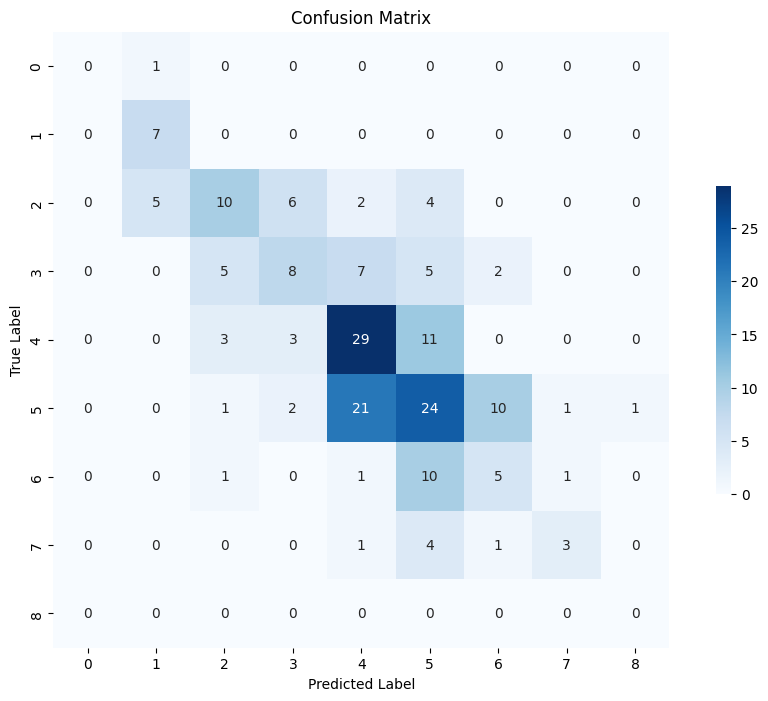

In [20]:
# Plot confusion matrix with better visualization
plt.figure(figsize=(12, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            square=True, cbar_kws={"shrink": .5})
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

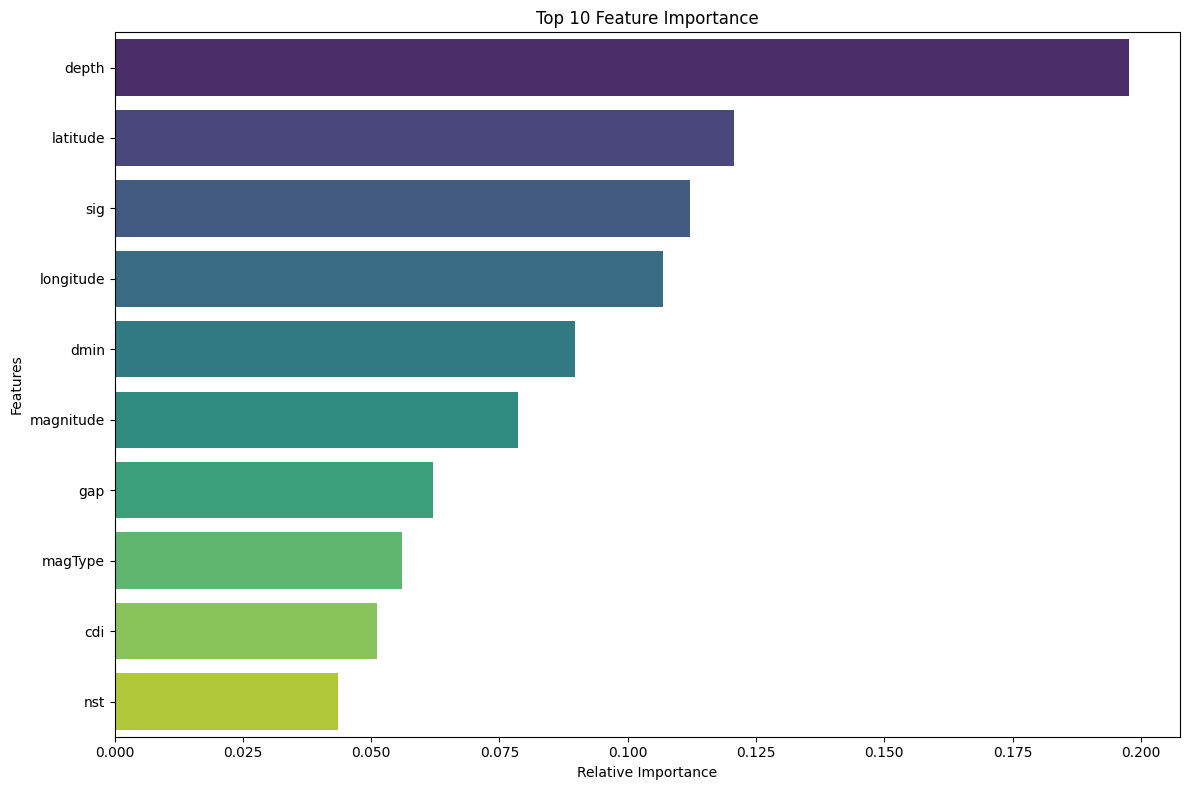

In [21]:
# Plot feature importance with improved styling
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', 
            data=feature_importance.head(10),
            palette='viridis')
plt.title('Top 10 Feature Importance')
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [22]:
from pathlib import Path
import pickle

# Create the models directory path using Path
models_dir = Path("../../Notebooks/Predictions_Training/Models")

# Files to save
files_to_save = {
    'mmi_transformers.pkl': transformers,
    'mmi_selected_features.pkl': selected_features,
    'mmi_feature_info.pkl': {'categorical_features': list(categorical_features),
                             'numerical_features': list(numerical_features)},
    'mmi_model.pkl': rf_model
}

# Save all necessary files
for filename, content in files_to_save.items():
    file_path = models_dir / filename  # Use / to combine Path object and filename
    with open(file_path, 'wb') as f:
        pickle.dump(content, f)

print(f"\nAll model artifacts saved in {models_dir}")



All model artifacts saved in ..\..\Notebooks\Predictions_Training\Models
